![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

#Summary

The goal of this asssignment is to build a convolutional neural network that assigns images in the CIFAR10 dataset from the Keras library to 10 different categories with an accuracy of at least 80% on the test set. The dataset is loaded directly from the Keras library and split into training set, validation set and test set. A total number of six networks are trained throughout this assignment, and the best performing one is used for the final predictions.

We start out with a simple neural network, which includes only a few layers and 284,010 trainable parameters (1.08 MB). We also set up the Optimizer and error function and make sure the input size of the images is correct. We start training the network with a batch size of 64 for 30 epochs. The test accuracy of this simple network is only 62.25%, still quite far from the target of 80%.

We optimize the next network by including "Early stopping", a learning rate scheduler and a higher number of convolutions and Dense layers. The number of trainable parameters increases to 530,282 (2.02 MB). To prevent overfitting the "shuffle" parameter is set to "True" during model training. Once we start using augmented data to train the network and increasing the number of epochs to 50 the test accuracy increases to more than 80% for the first time.

The third network is trained with different network parameters (1,056,938/4.03 MB) as we increase the filter size in the Convolutions as well as the number of units in the Dense layers. Besides, the "Early Stopping" parameters are changed to possibly decrease training time, and we keep training with the augmented dataset. In this network the learning rate is not adjusted automatically after 10 epochs buy only when validation loss reaches a plateau. Thanks to these optimization the test accuracy of this model is 82.25%.

The fourth network includes some dropout in the convolution layers, which aims at reducing overfitting. The rest of the settings and parameters remain the same as in the third network, as well the number of trainable parameters. While still being within the target the test accuracy is now slightly lower than before, 81.48%.

In an attept to improve the test accuracy again the size of the Convolution layers and the number of units in the Dense layers is increased in the fifth network, which leads to 2,823,402 trainable parameters (10.77 MB). The test accuracy of this network is 81.75%, so despite having less trainable parameters Model3 remains the best-performing one.

Even when removing the dropout again in the sixth network the test accuracy does not reach the same level as the third network, it goes only up to 81.50%.

Since the third model has the highest test accuracy it is used to make the final predictions. In those predictions 17 out of 20 images are classified correctly by the network, which is in line with the test accuracy of 82.25%.



## 1. Libraries

Load all necessary libraries

In [ ]:
#basic libraries: matplotlib, numpy, random, time, datetime
from matplotlib import pyplot as plt
import numpy as np
import random
import time
import datetime

#tensor flow and keras
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

#sklearn
from sklearn.preprocessing import LabelEncoder

## 2. Model network architecture

Our first model includes two Convolution layers, two MaxPooling layers, one Flattening layer and finally three Dense layers. The activation function in the last layer is "Softmax" since this is a non-binary Classification problem.

In [ ]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

Show summary of the model

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_17 (Dense)            (None, 64)               

## 3. Optimizer, error function


In [ ]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. We prepare the data

The CIFAR10 dataset is loaded directly from the Keras libraries. It is already split in train and test set.

To obtain the correct input format for the neural network the data needs to be divided by 255.0.

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

We obtain an array with all the labels of CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Next, we show a sample of the dataset using the PlotLy Get_cmap() method.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


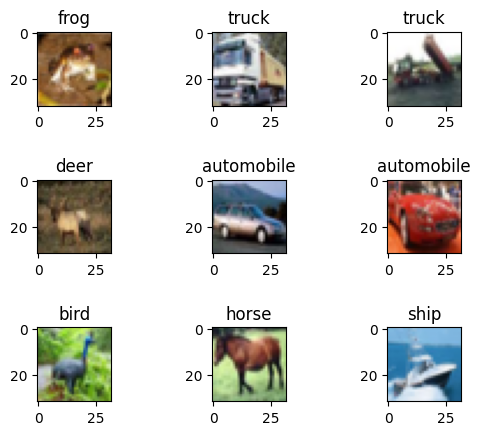

In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Part of the training data is saved as a validation set so that we can validate while we train.

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
x_train[0].shape

(32, 32, 3)

Check the size and shape of our training, test and validation set

In [ ]:
# We validate the result
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


## 5. Training

The model will be trained or 30 epochs for now, with a batch size of 64.

In [ ]:
t = time.perf_counter()

In [ ]:
history = model.fit(x_train, y_train, epochs=30,
                    use_multiprocessing=False, batch_size= 64,
                    validation_data=(x_val, y_val))

Epoch 1/30
625/625 [==============================] - 8s 7ms/step - loss: 1.5627 - accuracy: 0.4291 - val_loss: 1.3053 - val_accuracy: 0.5239
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 1.1735 - accuracy: 0.5814 - val_loss: 1.1027 - val_accuracy: 0.6071
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 1.0229 - accuracy: 0.6404 - val_loss: 1.0209 - val_accuracy: 0.6433
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.9284 - accuracy: 0.6770 - val_loss: 0.9740 - val_accuracy: 0.6642
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.8516 - accuracy: 0.7040 - val_loss: 0.9710 - val_accuracy: 0.6629
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 0.7917 - accuracy: 0.7228 - val_loss: 0.9258 - val_accuracy: 0.6835
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7352 - accuracy: 0.7453 - val_loss: 0.9081 - val_accuracy: 0.6935
Epoch 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:01:43.336752


In [ ]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 65.250


The test accuracy is still pretty low, so the model will be optimized further.

 ## 6. Model Optimization

###Model2

We will make use of the following optimization techniques:

*   Data augmentation
*   "Early Stopping"
*   Implement a "Learning Rate Scheduler" to reduce the learning rate as the model advances
*   Model parameters: more Convolutions, more Dense layers
*   To prevent overfitting: set "shuffle" parameter to "True" during model training









First, we prepare the data augmentation:

In [ ]:
#encode training data and validation data for data augmentation
y_train_img = y_train
x_train_img = x_train
y_val_img = y_val
x_val_img = x_val
le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
y_train_encoded

array([6, 9, 9, ..., 6, 2, 8])

Prepare the generators for training and validation data

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip = True,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img,
    y_train_encoded,
    batch_size=50
)

In [ ]:
validation_datagen = ImageDataGenerator(
    )
validation_generator = validation_datagen.flow(
    x_val_img,
    y_val_encoded,
    batch_size=20
)

Visualize some of the data augmentation samples

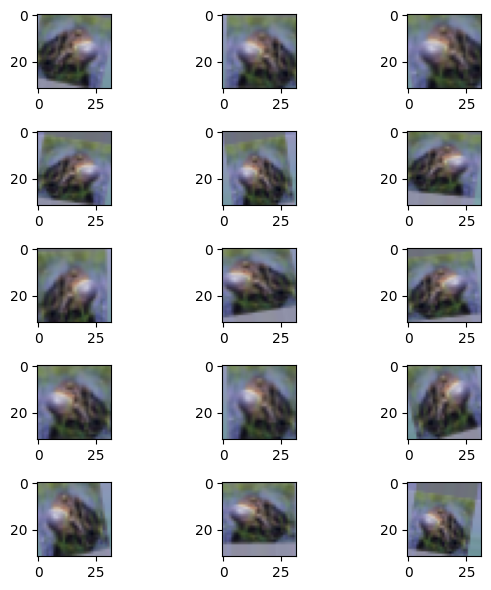

In [ ]:
sample = random.choice(range(0,49999))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_encoded[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(6, 6))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()

Implement "Early stopping":

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=20)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=20)

With the learning rate scheduler the learning rate is automatically reduced after 10 training epochs:

In [ ]:
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

step_decay_scheduler = LearningRateScheduler(step_decay)

Optimize Model Parameters:




In [ ]:
model2 = ks.Sequential()

#add more Convolutions
model2.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model2.add(ks.layers.MaxPooling2D((2, 2)))

model2.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model2.add(ks.layers.MaxPooling2D((2, 2)))

model2.add(ks.layers.Conv2D(128, (3, 3),  strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3)))
model2.add(ks.layers.MaxPooling2D(2,2))

model2.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3) ))
model2.add(ks.layers.MaxPooling2D(2,2))

model2.add(ks.layers.Flatten())

#more Dense layers
model2.add(ks.layers.Dense(128, activation='relu'))
model2.add(ks.layers.Dense(64, activation='relu'))
model2.add(ks.layers.Dense(32, activation='relu'))
model2.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 128)        

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

First, the model is trained only on the original training data, without augmented data.

In [ ]:
t = time.perf_counter()

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=50,
                    use_multiprocessing=False, batch_size=64,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    callbacks=[step_decay_scheduler, callback_loss, callback_accuracy])

Epoch 1/50
625/625 [==============================] - 11s 8ms/step - loss: 1.6558 - accuracy: 0.3798 - val_loss: 1.3103 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.1644 - accuracy: 0.5798 - val_loss: 1.0796 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9555 - accuracy: 0.6611 - val_loss: 0.9071 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8041 - accuracy: 0.7163 - val_loss: 0.8797 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 5s 8ms/step - loss: 0.6876 - accuracy: 0.7598 - val_loss: 0.8598 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.5867 - accuracy: 0.7940 - val_loss: 0.8372 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - l

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:02:09.038361


In [ ]:
_, acc2 = model2.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc2 * 100.0))

> 75.080


Despite our efforts to shuffle the training data there is still some massive overfitting in this new model since the training accuracy is 100% at the end, but validation accuracy and test accuracy are far from that.

Next, we will compile the model again and run it using the augmented training and validation data from the data generators. The maximum number of epochs is set to 50.

In [ ]:
t = time.perf_counter()

In [ ]:
history2_aug = model2.fit(train_generator, epochs=50,
                    validation_data=validation_generator,
                    steps_per_epoch= 700, validation_steps=150,
                    callbacks=[step_decay_scheduler, callback_loss, callback_accuracy])

Epoch 1/50
700/700 [==============================] - 27s 36ms/step - loss: 1.8009 - accuracy: 0.3280 - val_loss: 1.4753 - val_accuracy: 0.4513 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 26s 37ms/step - loss: 1.4159 - accuracy: 0.4846 - val_loss: 1.2204 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 25s 36ms/step - loss: 1.2481 - accuracy: 0.5513 - val_loss: 1.0813 - val_accuracy: 0.6183 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 34s 49ms/step - loss: 1.1332 - accuracy: 0.5956 - val_loss: 1.0050 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 5/50
700/700 [==============================] - 26s 37ms/step - loss: 1.0547 - accuracy: 0.6251 - val_loss: 0.9106 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 30s 42ms/step - loss: 0.9844 - accuracy: 0.6521 - val_loss: 0.8889 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 27s 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:26:50.370980


In [ ]:
_, acc2_aug = model2.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc2_aug * 100.0))

> 80.900


Thanks to the data augmentation and the test accuracy could be improved significantly, from 75.08% to 80.90%.




###Model3

Next optimization steps:
*   Increase model parameters: filter size in Convolutions, number of units in Dense layers
*   Change "Early Stopping" parameters to 10 to possibly decrease training time   
*   Keep training with augmented dataset as this obviously has a very positive impact on the test accuracy
*   Adjust the learning rate not automatically after 10 epochs but when validation loss reaches plateau

In [ ]:
model3 = ks.Sequential()

model3.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model3.add(ks.layers.MaxPooling2D((2, 2)))

model3.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model3.add(ks.layers.MaxPooling2D((2, 2)))

#increase filter size in Convolution layer
model3.add(ks.layers.Conv2D(256, (3, 3),  strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3)))
model3.add(ks.layers.MaxPooling2D(2,2))

model3.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3) ))
model3.add(ks.layers.MaxPooling2D(2,2))

model3.add(ks.layers.Flatten())

#increase number of units in Dense layer
model3.add(ks.layers.Dense(256, activation='relu'))
model3.add(ks.layers.Dense(128, activation='relu'))
model3.add(ks.layers.Dense(32, activation='relu'))
model3.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 256)         147712    
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 4, 4, 256)        

In [ ]:
#set patience to 10 instead of 20 to reduce training time
callback_lossb = EarlyStopping(monitor='val_loss', patience=10)
callback_accuracyb = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
#optimize learning rate on plateau
red_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model3.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

In [ ]:
history3 = model3.fit(train_generator, epochs=50,
                    validation_data=validation_generator,
                    steps_per_epoch= 700, validation_steps=150,
                    callbacks=[red_lr, callback_lossb, callback_accuracyb])

Epoch 1/50
700/700 [==============================] - 28s 36ms/step - loss: 1.7683 - accuracy: 0.3396 - val_loss: 1.4762 - val_accuracy: 0.4567 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 25s 36ms/step - loss: 1.3773 - accuracy: 0.4987 - val_loss: 1.1494 - val_accuracy: 0.5763 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 28s 39ms/step - loss: 1.2022 - accuracy: 0.5661 - val_loss: 1.0615 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 32s 46ms/step - loss: 1.0784 - accuracy: 0.6167 - val_loss: 0.9954 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 5/50
700/700 [==============================] - 29s 41ms/step - loss: 1.0027 - accuracy: 0.6476 - val_loss: 0.8474 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 31s 44ms/step - loss: 0.9482 - accuracy: 0.6656 - val_loss: 0.9452 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 30s 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:26:10.657458


In [ ]:
_, acc3 = model3.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc3 * 100.0))

> 82.250


With this new model the test accuracy could be improved a bit more, to 82.25%. The model needed 47 training epochs, slightly less than the possible maximum of 50.

There could still be some overfitting in this model since the training accuracy is still relatively high compared to the validation and test accuracies.

###Model4

 Next, we will try and see what happens when adding some dropout to the model, which is used to reduce overfitting.

In [ ]:
model4 = ks.Sequential()

model4.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model4.add(ks.layers.MaxPooling2D((2, 2)))

model4.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model4.add(ks.layers.MaxPooling2D((2, 2)))

model4.add(ks.layers.Conv2D(256, (3, 3),  strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3)))
model4.add(ks.layers.MaxPooling2D(2,2))

#add dropout in Convolution layers
model4.add(ks.layers.Dropout(0.2))

model4.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3) ))
model4.add(ks.layers.MaxPooling2D(2,2))

#add dropout in Convolution layers
model4.add(ks.layers.Dropout(0.2))

model4.add(ks.layers.Flatten())
model4.add(ks.layers.Dense(256, activation='relu'))
model4.add(ks.layers.Dense(128, activation='relu'))
model4.add(ks.layers.Dense(32, activation='relu'))
model4.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 256)         147712    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 4, 4, 256)        

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model4.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

In [ ]:
history4 = model4.fit(train_generator, epochs=50,
                    validation_data=validation_generator,
                    steps_per_epoch= 700, validation_steps=150,
                    callbacks=[red_lr, callback_lossb, callback_accuracyb])

Epoch 1/50
700/700 [==============================] - 28s 35ms/step - loss: 1.7656 - accuracy: 0.3388 - val_loss: 1.4263 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 25s 35ms/step - loss: 1.3981 - accuracy: 0.4899 - val_loss: 1.1752 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 25s 35ms/step - loss: 1.2505 - accuracy: 0.5477 - val_loss: 1.0950 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 24s 35ms/step - loss: 1.1524 - accuracy: 0.5893 - val_loss: 0.9930 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 5/50
700/700 [==============================] - 24s 35ms/step - loss: 1.0713 - accuracy: 0.6201 - val_loss: 0.9032 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 24s 35ms/step - loss: 1.0109 - accuracy: 0.6421 - val_loss: 0.9128 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 30s 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:27:26.251808


In [ ]:
_, acc4 = model4.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc4 * 100.0))

> 81.480


The test accuracy is now slightly lower than before, 81.48%. The model needed all 50 training epochs.

###Model5

In the next model the filter size of the Convolution layers and the number of units in the Dense layers of the CNN will be increased further to see if that helps improve the test accuracy.

In [ ]:
model5 = ks.Sequential()

#increase filter size in Convolutions
model5.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model5.add(ks.layers.MaxPooling2D((2, 2)))

model5.add(ks.layers.Conv2D(128, (3, 3),  strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3)))
model5.add(ks.layers.MaxPooling2D(2,2))
model5.add(ks.layers.Dropout(0.2))

model5.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3) ))
model5.add(ks.layers.MaxPooling2D(2,2))
model5.add(ks.layers.Dropout(0.2))

#increase number of Units in Dense layers
model5.add(ks.layers.Flatten())
model5.add(ks.layers.Dense(512, activation='relu'))
model5.add(ks.layers.Dense(512, activation='relu'))
model5.add(ks.layers.Dense(32, activation='relu'))
model5.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 256)        

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model5.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

In [ ]:
history5 = model5.fit(train_generator, epochs=50,
                    validation_data=validation_generator,
                    steps_per_epoch= 700, validation_steps=150,
                    callbacks=[red_lr, callback_lossb, callback_accuracyb])

Epoch 1/50
700/700 [==============================] - 29s 38ms/step - loss: 1.8150 - accuracy: 0.3257 - val_loss: 1.4108 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 32s 46ms/step - loss: 1.4278 - accuracy: 0.4804 - val_loss: 1.2876 - val_accuracy: 0.5353 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 26s 37ms/step - loss: 1.2598 - accuracy: 0.5498 - val_loss: 1.0226 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 27s 39ms/step - loss: 1.1671 - accuracy: 0.5846 - val_loss: 1.0451 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 5/50
700/700 [==============================] - 29s 41ms/step - loss: 1.0959 - accuracy: 0.6105 - val_loss: 0.9876 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 26s 37ms/step - loss: 1.0371 - accuracy: 0.6292 - val_loss: 0.8731 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 27s 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:27:55.450249


In [ ]:
_, acc5 = model5.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc5 * 100.0))

> 81.750


The test accuracy has improved to 81.75%, but so far Model3 remains the best performing model with 82.25%

###Model6

Lastly, the dropout will be removed from the Convolutions again, to see if the test accuracy can be improved to more than 82.25% if the dropout is in the Dense layers instead.

In [ ]:
model6 = ks.Sequential()

#remove dropouts from convolutions
model6.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))
model6.add(ks.layers.MaxPooling2D((2, 2)))

model6.add(ks.layers.Conv2D(128, (3, 3),  strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3)))
model6.add(ks.layers.MaxPooling2D(2,2))

model6.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation = 'relu',
                            padding='same', input_shape =(32,32,3) ))
model6.add(ks.layers.MaxPooling2D(2,2))

#add slight dropout in Dense layers
model6.add(ks.layers.Flatten())
model6.add(ks.layers.Dense(512, activation='relu'))
model6.add(ks.layers.Dropout(0.2))
model6.add(ks.layers.Dense(512, activation='relu'))
model6.add(ks.layers.Dense(32, activation='relu'))
model6.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 4, 4, 256)        

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model6.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

In [ ]:
history6 = model6.fit(train_generator, epochs=50,
                    validation_data=validation_generator,
                    steps_per_epoch= 700, validation_steps=150,
                    callbacks=[red_lr, callback_lossb, callback_accuracyb])

Epoch 1/50
700/700 [==============================] - 29s 38ms/step - loss: 1.7416 - accuracy: 0.3502 - val_loss: 1.3995 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 32s 46ms/step - loss: 1.3614 - accuracy: 0.5069 - val_loss: 1.1945 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 29s 42ms/step - loss: 1.1899 - accuracy: 0.5771 - val_loss: 1.0279 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 26s 37ms/step - loss: 1.0875 - accuracy: 0.6173 - val_loss: 0.8459 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 5/50
700/700 [==============================] - 27s 38ms/step - loss: 1.0164 - accuracy: 0.6459 - val_loss: 0.9003 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 26s 37ms/step - loss: 0.9554 - accuracy: 0.6661 - val_loss: 0.7917 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 27s 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:18:52.656896


In [ ]:
_, acc6 = model6.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc6 * 100.0))

> 81.500


This model trained in under 20 minutes, which makes it the model with the shortest training time among those models that were trained with data augmentation. The test accuracy of Model6 is below 82%, which is why Model3 remains our best performing model.

## 7. We evaluate the results


It should be mentioned that the test accuracies of Model2, Model3, Model4, Model5 and Model6 (all models that were trained with augmented data) are pretty similar, only the test accuracy of the first model is significantly lower.


*   Model1: 62.25%
*   Model2: 80.90%
*   Model3: 82.25%
*   Model4: 81.48%
*   Model5: 81.75%
*   Model6: 81.50%

Since there is a lot of randomness involved in training neural networks it is possible that if these models are trained again the test accuracies vary and a different model will be the one with the best performance.

The evaluation of the Cross Entropy loss and the Classification Accuracy of Model3 are visualized.

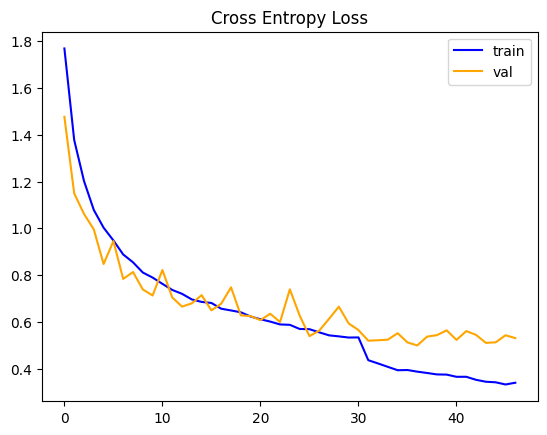

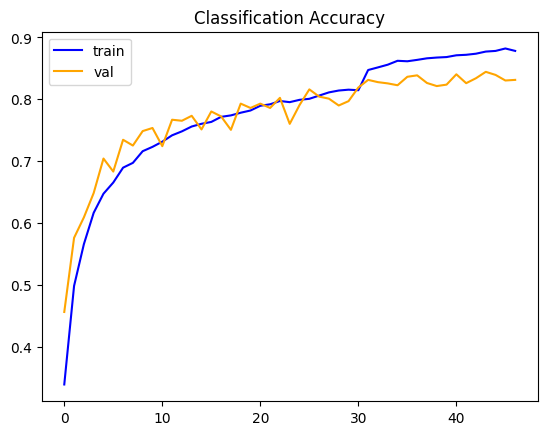

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history3.history['loss'], color='blue', label='train')
plt.plot(history3.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history3.history['accuracy'], color='blue', label='train')
plt.plot(history3.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Some predictions are created with the test set and visualized

In [ ]:
predictions = model3.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Define visualization function

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

Visualize predictions: Correct predictions are shown in blue, wrong predictions in red.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


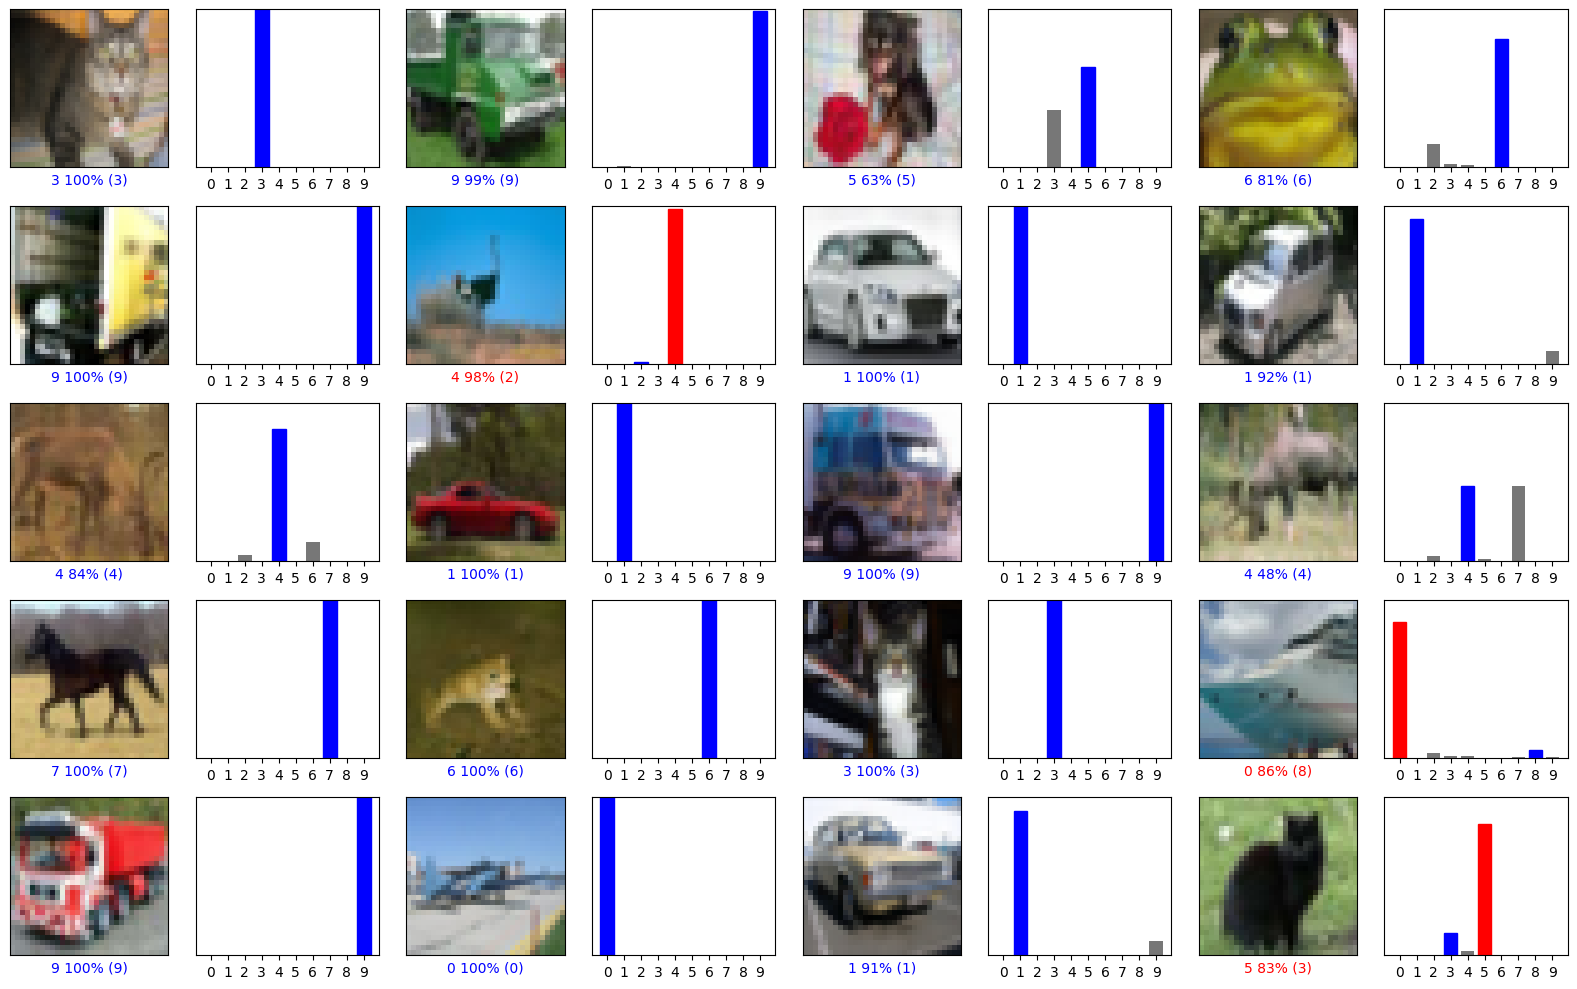

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

17 out of 20 images are predicted correctly (85%), which is in line with our 82.25% test accuracy.

## 8. We save the models for future evaluations

In [ ]:
model.save('cifar10_base_model.h')

In [ ]:
model2.save('cifar10_base_model.h2')

In [ ]:
model3.save('cifar10_base_model.h3')

In [ ]:
model4.save('cifar10_base_model.h4')

In [ ]:
model5.save('cifar10_base_model.h5')

In [ ]:
model6.save('cifar10_base_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
